# SHAP
Initialise Shap Explainer and help functions

In [32]:
import numpy as np
from datasets import load_dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import shap
import requests
from io import BytesIO
import tensorflow as tf

model = load_model('model_0.781.keras')

# Function to preprocess an image from a URL or image object
def preprocess_image(image, target_size):
    if isinstance(image, str):
        response = requests.get(image)
        img = load_img(BytesIO(response.content), target_size=target_size)
    else:
        img = image.resize(target_size)
    img_array = img_to_array(img) / 255.0
    img_array = (img_array - 0.5) * 2
    return img_array

# Load the Hugging Face Pokemon dataset
dataset = load_dataset("keremberke/pokemon-classification", 'full', split="train")
target_size = (160, 160)

x_test_mstar = np.array([preprocess_image(sample['image'], target_size) for sample in dataset.select(range(100, 150))])

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(32,32)", np.array(x_test_mstar[0]).shape)

num_classes = len(dataset.features['labels'].names)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(num_classes)))

def analyze_image_url(image_url):
    x_test_sample = preprocess_image(image_url, target_size)
    
    # Make a prediction for the image
    prediction = model(np.array([x_test_sample]))
    prediction_probabilities = tf.nn.softmax(prediction).numpy()
    predicted_class_idx = np.argmax(prediction_probabilities, axis=-1)[0]
    predicted_class_name = sorted(dataset.features['labels'].names)[predicted_class_idx]
    print(f"Model Prediction: {predicted_class_name} (Class Index: {predicted_class_idx})")

    shap_values_ = explainer(np.array([x_test_sample]), max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values_, labels=list(range(num_classes)))

Analyse Image

Model Prediction: Psyduck (Class Index: 110)


PartitionExplainer explainer: 2it [00:57, 57.86s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


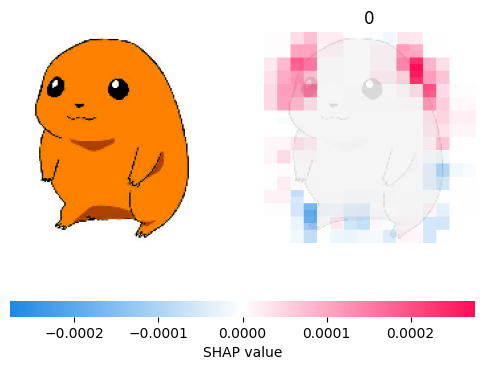

In [33]:
image_url = "https://pbs.twimg.com/media/FZw4aFfX0AAOQud.jpg"
analyze_image_url(image_url)

No red cheeks: https://i.redd.it/heres-a-couple-of-alternate-shinies-for-pikachu-with-v0-bn2u2txa7s6d1.jpg?width=1980&format=pjpg&auto=webp&s=0c83d523d903b23bd54e16f811cd8c3d19d9f5cf
No wings, ears: https://64.media.tumblr.com/351f1da186047c6983d736c04aeb384d/tumblr_inline_mwxr2bBkWP1rt8g6r.png
No wings, ears, cheeks: https://64.media.tumblr.com/a0b81a032e37afd2ae49dd8d0fa54084/tumblr_inline_mwxr7p7Z8L1rt8g6r.png
No wings, ears, cheecks, mouth closed: https://pbs.twimg.com/media/FZw4aFfX0AAOQud.jpg